In [1]:
from torchvision.io import read_image
from matplotlib import pyplot as plt

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

# Models and pre-trained weights
[Additional Reading](https://pytorch.org/vision/stable/models.html)

The torchvision.models subpackage contains definitions of models for addressing different tasks, including: image classification, pixelwise semantic segmentation, object detection, instance segmentation, person keypoint detection, video classification, and optical flow.

In [33]:
from torchvision import models
dir(models)

['AlexNet',
 'AlexNet_Weights',
 'ConvNeXt',
 'ConvNeXt_Base_Weights',
 'ConvNeXt_Large_Weights',
 'ConvNeXt_Small_Weights',
 'ConvNeXt_Tiny_Weights',
 'DenseNet',
 'DenseNet121_Weights',
 'DenseNet161_Weights',
 'DenseNet169_Weights',
 'DenseNet201_Weights',
 'EfficientNet',
 'EfficientNet_B0_Weights',
 'EfficientNet_B1_Weights',
 'EfficientNet_B2_Weights',
 'EfficientNet_B3_Weights',
 'EfficientNet_B4_Weights',
 'EfficientNet_B5_Weights',
 'EfficientNet_B6_Weights',
 'EfficientNet_B7_Weights',
 'EfficientNet_V2_L_Weights',
 'EfficientNet_V2_M_Weights',
 'EfficientNet_V2_S_Weights',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'GoogLeNet_Weights',
 'Inception3',
 'InceptionOutputs',
 'Inception_V3_Weights',
 'MNASNet',
 'MNASNet0_5_Weights',
 'MNASNet0_75_Weights',
 'MNASNet1_0_Weights',
 'MNASNet1_3_Weights',
 'MaxVit',
 'MaxVit_T_Weights',
 'MobileNetV2',
 'MobileNetV3',
 'MobileNet_V2_Weights',
 'MobileNet_V3_Large_Weights',
 'MobileNet_V3_Small_Weights',
 'RegNet',
 'RegNet_X_16GF_Weights'

### Initializing pre-trained models

In [ ]:
#if you get ssl error run following
#import ssl
#ssl._create_default_https_context = ssl._create_stdlib_context

resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

resnet.eval() # we will be using the model for evaluation not training. This step is important as some models have different behaviour at traing and eval time

In [ ]:
weights=models.ResNet50_Weights.DEFAULT
weights.meta["categories"]

### Using the pre-trained models
Before using the pre-trained models, one must preprocess the image (resize with right resolution/interpolation, apply inference transforms, rescale the values etc). There is no standard way to do this as it depends on how a given model was trained. It can vary across model families, variants or even weight versions. Using the correct preprocessing method is critical and failing to do so may lead to decreased accuracy or incorrect outputs.

All the necessary information for the inference transforms of each pre-trained model is provided on its weights documentation. To simplify inference, TorchVision bundles the necessary preprocessing transforms into each model weight. These are accessible via the weight.transforms attribute:

mountain bike: 22.654999792575836%


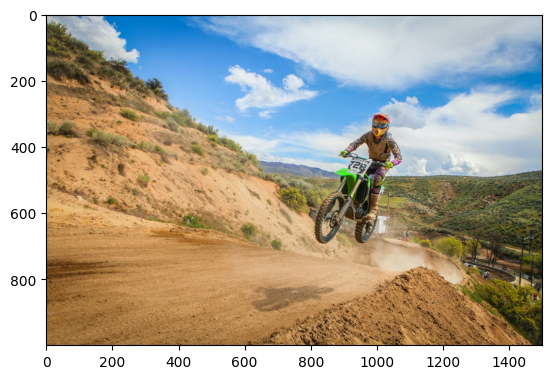

In [32]:
# Initialize the Transforms (preprocessing)
preprocess = models.ResNet50_Weights.DEFAULT.transforms()

# Read image using Pytorch read_image
img = read_image('./data/images/motorbike.jpeg')

### or get the image from internet using the following:
#from PIL import Image
#import requests
#img = Image.open(requests.get('http://farm8.staticflickr.com/7090/7399887950_8845d3e6e4_z.jpg', stream=True).raw)


# Apply the preprocessing to the input image. Preprocess accepts Pytorch tensor or PIL image
batch = preprocess(img).unsqueeze(0) # unsqueeze will reshape the tensor to the correct shape

# Apply the model to the image
prediction = resnet(batch).squeeze(0).softmax(0)
class_id = prediction.argmax().item()
score = prediction[class_id].item()
category_name = weights.meta["categories"][class_id]
print(f"{category_name}: {100 * score}%")

# Display the image
plt.imshow(transforms.ToPILImage()(img))
#plt.imshow(img) #if the img is already a PIL image

In [34]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Fine tuning
Rather than training from scratch, the preferred technique is transfer learning, achieved by fine-tuning pre-trained models on custom datasets. By following this approach we use their existing knowledge and tailor them to our specific tasks, thereby conserving significant time and computational resources

In [7]:
num_classes = 10 # let say we want to finetune resnet on a dataset containing 10 classes

# Load pre-trained model 
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
preprocess = models.ResNet50_Weights.DEFAULT.transforms()

# Freeze layer weights
for param in model.parameters():
    param.requires_grad = False
    
# Modify the model head for fine-tuning
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)


In [8]:
torch.manual_seed(0)
transform=transforms.Compose([transforms.ToTensor(),
                              preprocess])
trainset = datasets.CIFAR10(
    root='~/Downloads/',
    train=True,
    download=True,
    transform=transform
)

testset = datasets.CIFAR10(
    root='~/Downloads/',
    train=False,
    download=True,
    transform=transform
)

batchsize = 64
trainloader = DataLoader(trainset, batch_size=batchsize, shuffle=True)
testloader = DataLoader(testset, batch_size=batchsize, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
device = torch.device('mps')
criteria = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
train_history = []
val_history = []

In [13]:
# Training loop
model.to(device)
model.train() # tell the model that your are trainin the model

for epoch in range(10):
    train_loss = 0.0
    for i, data in enumerate(trainloader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()  
        outputs = model(inputs)
        
        loss = criteria(outputs, labels)
        loss.backward()
        
        optimizer.step()
        
        train_loss += loss.item()

    # validation
    with torch.no_grad():
        val_loss = 0
        for data in testloader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criteria(outputs, labels)
            val_loss += loss.item()
            
    print(f'Epoch [{epoch}], train loss: {train_loss/len(trainset)}, val loss: {val_loss/len(testset)}')        
    train_history += [train_loss/len(trainset)]
    val_history += [val_loss/len(testset)]
print("Finished Training")

Epoch [0], train loss: 0.01207187051475048, val loss: 0.010548204147815704
Epoch [1], train loss: 0.009719989528656006, val loss: 0.009581494888663292
Epoch [2], train loss: 0.008856054700613021, val loss: 0.009360866487026215
Epoch [3], train loss: 0.008401263421177864, val loss: 0.009133500689268112
Epoch [4], train loss: 0.008027815747857095, val loss: 0.008997839885950088
Epoch [5], train loss: 0.007772571674883366, val loss: 0.008883554923534393


KeyboardInterrupt: 

/var/folders/0z/jwyfm58j7tj7lm38fjwq8dvw0000gq/T/ipykernel_44582/1543011309.py:7: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  plt.legend('train loss', 'val loss')


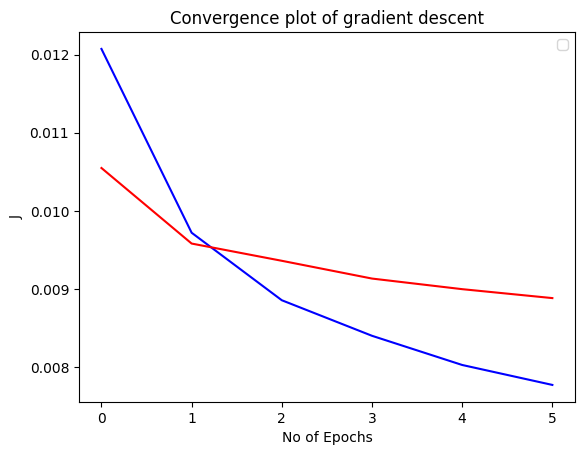

In [14]:
from matplotlib import pyplot as plt
plt.plot(train_history, 'b')
plt.plot(val_history, 'r')
plt.title('Convergence plot of gradient descent')
plt.xlabel('No of Epochs')
plt.ylabel('J')
plt.legend('train loss', 'val loss')
plt.show()

Actual cat	Predicted: cat
Actual ship	Predicted: ship
Actual ship	Predicted: ship
Actual airplane	Predicted: airplane
Actual frog	Predicted: frog
Actual frog	Predicted: frog
Actual automobile	Predicted: automobile
Actual frog	Predicted: frog
Actual cat	Predicted: cat
Actual automobile	Predicted: automobile


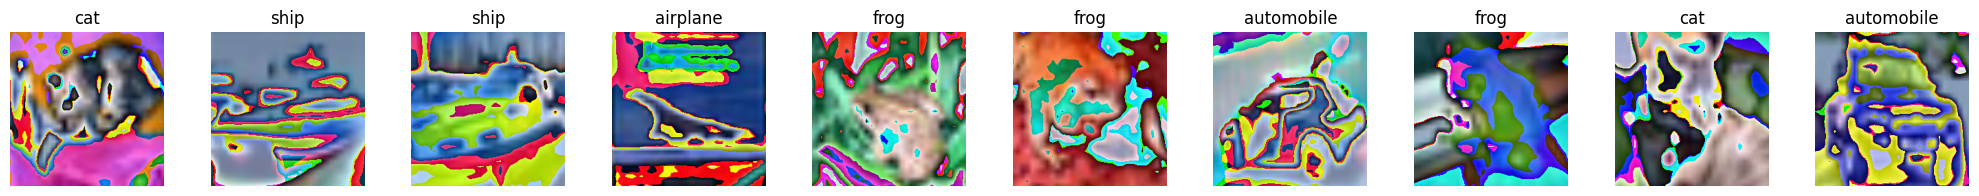

In [15]:
transform_back = transforms.Compose([transforms.Normalize((-1.,-1.,-1.),(2.,2.,2.)), 
                            transforms.ToPILImage()])

idx_to_class = {value: key for key, value in trainset.class_to_idx.items()}

images, labels = next(iter(testloader))
images = images.to(device)
labels = labels.to(device)
    
outputs = model(images)
_, predicted = torch.max(outputs, dim=1)

plt.figure(figsize=(20,30))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.tight_layout()
    plt.imshow(transform_back(images[i]))
    plt.axis('off')
    plt.title(idx_to_class[predicted[i].item()])
    print(f"Actual {idx_to_class[labels[i].item()]}\tPredicted: {idx_to_class[predicted[i].item()]}")
plt.show()

In [17]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %%')

Accuracy of the network on the 10000 test images: 80.7 %%


In [18]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 